setup: open trades database and table epex_12_20_12_13

# FlexPower Interview tasks -- Testbook

## Task 1 Minimal reporting tool

### set up and data import

In [68]:
#PYTHON 3.9.6

In [16]:
import sqlite3
import pandas as pd

In [ ]:
con = sqlite3.connect("trades.sqlite")
trades = pd.read_sql_query("SELECT * from epex_12_20_12_13", con)
#TODO: check this is reading all of them in
print(trades.head())
con.close()
print(trades.size, trades.shape)

        id  quantity  price  side    strategy
0  trade_1         5   20.0   buy  strategy_1
1  trade_2        17   10.0  sell  strategy_1
2  trade_3        15    8.0   buy  strategy_1
3  trade_4        13   35.0  sell  strategy_2
4  trade_5        23   11.0  sell  strategy_2
30 (6, 5)


In [33]:
print(trades)

        id  quantity  price  side    strategy
0  trade_1         5   20.0   buy  strategy_1
1  trade_2        17   10.0  sell  strategy_1
2  trade_3        15    8.0   buy  strategy_1
3  trade_4        13   35.0  sell  strategy_2
4  trade_5        23   11.0  sell  strategy_2
5  trade_6         8   20.0   buy  strategy_2


In [57]:
#TODO: quick data cleaner making sure evth is in the right type

### Task 1.1
Write a function that computes the total buy volume for flex power, another that computes the total sell volume.

In [22]:

def compute_total_buy_volume(tradetable) -> float:
    total_buy = tradetable[tradetable.side == 'buy'].quantity.sum()
    return total_buy

def compute_total_sell_volume(tradetable) -> float:
    total_sell = tradetable[tradetable.side == 'sell'].quantity.sum()
    return total_sell

In [23]:
compute_total_buy_volume(trades)
compute_total_sell_volume(trades)

np.int64(53)

In [ ]:
#TODO: change to dataframe.filter for efficiency (in case tested on a bigger database)

### Task 1.2
PnL calculation for each strategy; defn sum of incomes, with selling +ve and buying -ve

In [24]:
print(trades.strategy.unique())

['strategy_1' 'strategy_2']


In [65]:
def compute_pnl(strategy_id: str, tradetable) -> float:
    if strategy_id in tradetable.strategy.unique():
        this_strategy_trades_sell = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'sell')]
        this_strategy_trades_buy = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'buy')]
        sales = this_strategy_trades_sell.quantity * this_strategy_trades_sell.price
        sales_value = sales.sum()
        buys = this_strategy_trades_buy.quantity * this_strategy_trades_buy.price
        buys_value = buys.sum()
        income = sales_value - buys_value
    else:
        income = 0
    return income
#make this smarter anad use the buy sell volume funcs from above?
#use .dot explicityly rather than *? check know behaviour of this?
#change to not do memory allocation (change to a lambda function? rather than data slicing?

In [67]:
compute_pnl('strategy_2',trades)

np.float64(548.0)

### Task 1.3
expose compute_pnl as the entrypoint of a web application

import requests as rq

class Api:
    def compute_pnl(strategy_id: str, tradetable) -> float:
        if strategy_id in tradetable.strategy.unique():
            this_strategy_trades_sell = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'sell')]
            this_strategy_trades_buy = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'buy')]
            sales = this_strategy_trades_sell.quantity * this_strategy_trades_sell.price
            sales_value = sales.sum()
            buys = this_strategy_trades_buy.quantity * this_strategy_trades_buy.price
            buys_value = buys.sum()
            income = sales_value - buys_value
        else:
            income = 0
        return income

from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route("/pnl/<strategy_id>")
def compute_pnl(strategy_id: str, tradetable) -> float:
        if strategy_id in tradetable.strategy.unique():
            this_strategy_trades_sell = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'sell')]
            this_strategy_trades_buy = tradetable[(tradetable.strategy == strategy_id) & (tradetable.side == 'buy')]
            sales = this_strategy_trades_sell.quantity * this_strategy_trades_sell.price
            sales_value = sales.sum()
            buys = this_strategy_trades_buy.quantity * this_strategy_trades_buy.price
            buys_value = buys.sum()
            income = sales_value - buys_value
        else:
            income = 0
        return jsonify(income),200

can't figure out how to do this yet; move on and check back in later

## Task 2

### Set up and data imports

In [ ]:
import openpyxl

ModuleNotFoundError: No module named 'matplotlib'

In [81]:
task2df = pd.read_excel('analysis_task_data.xlsx',sheet_name='DE_Wind_PV_Prices')

In [ ]:
print(task2df.size,task2df.shape)

350400 (35040, 10)


In [92]:
task2df.shape[0]/365/24/4

1.0

In [93]:
task2df.columns

Index(['hour', 'time', 'Wind Day Ahead Forecast [in MW]',
       'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]',
       'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]',
       'Intraday Price Price Quarter Hourly  [in EUR/MWh]',
       'Intraday Price Hourly  [in EUR/MWh]',
       'Imbalance Price Quarter Hourly  [in EUR/MWh]'],
      dtype='object')

### Task 2.1
How much Wind/PV Power was forecasted to produced in German in 2021 [in MWh] on Day Ahead (da) and on Intraday (id). Hint: Be careful: you have values in MW on a quarter hourly basis, think how this translates into hourly values.

In [95]:
da_wind_forecast_total_mwh = task2df['Wind Day Ahead Forecast [in MW]'].sum()/4
print(da_wind_forecast_total_mwh)

115395406.25


In [96]:
da_pv_forecast_total_mwh = task2df['PV Day Ahead Forecast [in MW]'].sum()/4
print(da_pv_forecast_total_mwh)

46094572.75


In [98]:
id_wind_forecast_total_mwh = task2df['Wind Intraday Forecast [in MW]'].sum()/4
print(id_wind_forecast_total_mwh)

113478034.5


In [100]:
id_pv_forecast_total_mwh = task2df['PV Intraday Forecast [in MW]'].sum()/4
print(id_pv_forecast_total_mwh)

46689891.5


In [103]:
#2 graphs of forecast production for wind and solar da and id
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


figure, axis = plt.subplots(1, 2)

axis[0, 0].plot(X, )
axis[0, 0].plot(X, )
axis[0, 0].set_title("Solar production forecasts (Cumulative, MWh)")

axis[0, 1].plot(X, )
axis[0, 1].set_title("Wind production forecasts (Cumulative, MWh)")

### Task 2.2
Show the average Wind/Solar production for 2021 over a 24h period for Intraday and Day Ahead (4 lines in one graph).

In [113]:
import numpy as np

In [123]:
#find the average wind production in a 24h period on da
#have the hour of the day; group by hour, take the average for that hour, remember /4
da_wind_24h_av_production = task2df.groupby(by='hour').agg({'Wind Day Ahead Forecast [in MW]':'mean'}).reindex()
da_wind_24h_av_production = da_wind_24h_av_production['Wind Day Ahead Forecast [in MW]'] / 4
#print(da_wind_24h_av_production)

In [ ]:
#find the average wiind production in a 24h period on id
id_wind_24h_av_production = task2df.groupby(by='hour').agg({'Wind Intraday Forecast [in MW]':'mean'}).reindex()
id_wind_24h_av_production = id_wind_24h_av_production['Wind Intraday Forecast [in MW]'] / 4

77724.68116438357


In [ ]:
#find the 24h average solar production in a 24 h period on da
da_solar_24h_av_production = task2df.groupby(by='hour').agg({'PV Day Ahead Forecast [in MW]':'mean'}).reindex()

In [107]:
#find the average solar production in a 24h period on id

In [136]:
#create a new dataframe grouped by hour with the mean of each hour
av_24h = task2df.groupby(by='hour').agg({'Wind Day Ahead Forecast [in MW]':'mean',
                                         'Wind Intraday Forecast [in MW]':'mean',
                                         'PV Day Ahead Forecast [in MW]':'mean',
                                         'PV Intraday Forecast [in MW]':'mean'}).reindex()
#print(av_24h.index)
#print(av_24h.head(2))
av_24h = av_24h/4
#print(av_24h.head(2))

Text(0, 0.5, 'Average production (MW)')

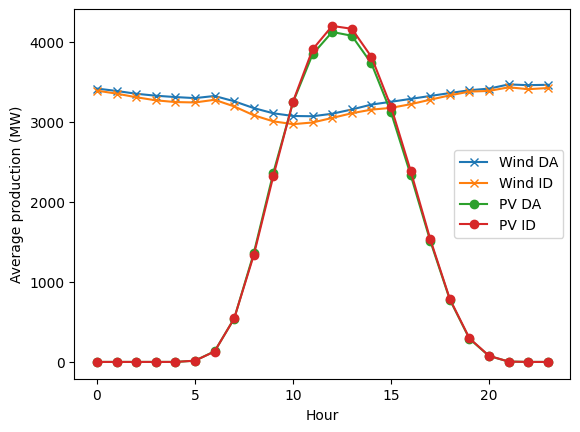

In [147]:
#plot all 4 on the same graph
X = av_24h.index
plt.plot(X, av_24h['Wind Day Ahead Forecast [in MW]'],label='Wind DA',marker='x')
plt.plot(X, av_24h['Wind Intraday Forecast [in MW]'], label='Wind ID',marker='x')
plt.plot(X, av_24h['PV Day Ahead Forecast [in MW]'], label='PV DA',marker='o')
plt.plot(X, av_24h['PV Intraday Forecast [in MW]'], label='PV ID',marker='o')
plt.legend(loc='center right')
plt.xlabel("Hour")
plt.ylabel("Average production (MW)")

### Task 2.3 
What was the average value [in EUR/MWh] for Wind/Solar Power in 2021 using the da forecast and using da h prices? The average value is defined as the average hourly value that a Wind/PV farm owner would have received for their product. Is the average value of Wind and PV higher or lower than the average da price? Why could it be higher/lower?

In [150]:
#average da price (cancels out that is repeated 4 times in each quarter)
av_da_price = task2df['Day Ahead Price hourly [in EUR/MWh]'].mean()
print(av_da_price)

96.84991780821919


#average value is sum DA forecast * dah price / count (do i exclude zero hours?); don't forget in 15mins not hrs
wind_produced = task2df[task2df['Wind Day Ahead Forecast [in MW]']>0]
wind_produced['value'] = 0.25*wind_produced['Wind Day Ahead Forecast [in MW]']*wind_produced['Day Ahead Price hourly [in EUR/MWh]']
#hours * MW * EUR/MWh = EUR
av_wind_value = wind_produced.value.sum()/(wind_produced['Wind Day Ahead Forecast [in MW]'].sum()*0.25)
#EUR / MW*hours
print(av_wind_value)

In [ ]:
#wind and solar average values are going to be weighted averages based on production in certain hours aat price x

In [163]:
av_wind_value_da = (0.25*task2df['Wind Day Ahead Forecast [in MW]']*task2df['Day Ahead Price hourly [in EUR/MWh]']).sum()/(0.25*task2df['Wind Day Ahead Forecast [in MW]'].sum())

In [161]:
print(av_wind_value_wzeroes)

81.38706977035753


In [162]:
#makes no difference having zeroes

In [166]:
av_pv_value_da = (0.25*task2df['PV Day Ahead Forecast [in MW]']*task2df['Day Ahead Price hourly [in EUR/MWh]']).sum()/(0.25*task2df['PV Day Ahead Forecast [in MW]']).sum()

In [167]:
print(av_pv_value_da)

76.89453079034125


Solar average price is 76.89 EUR/MWh (2sf); wind is approx 81.38 EUR/MWh (2sf); the average da h value for contrast is 96.84 EUR/MWh (2sf)
The average prices are lower because wind and solar are low marginal cost; when they are producing, they bring the price of electricity down. This is even more apparent when they are producing lots of power; the more of the required power they supply, the lower the price in a system where the day ahead price is set using a merit order

### Task 2.4
Find the Day with the highest renewable energy production and with the lowest renewable energy production in 2021. What was the average Day Ahead Price levels on these days? How do you explain the difference in prices?

In [174]:
#time column is a timestamp type
task2df['day'] = pd.to_datetime(task2df.time).dt.date
#print(task2df.tail(2))

In [176]:
print(task2df.columns)

Index(['hour', 'time', 'Wind Day Ahead Forecast [in MW]',
       'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]',
       'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]',
       'Intraday Price Price Quarter Hourly  [in EUR/MWh]',
       'Intraday Price Hourly  [in EUR/MWh]',
       'Imbalance Price Quarter Hourly  [in EUR/MWh]', 'day'],
      dtype='object')


In [190]:
data_by_day = task2df.groupby(by='day').agg({'Wind Day Ahead Forecast [in MW]':'sum',
                                             'Wind Intraday Forecast [in MW]': 'sum',
                                             'PV Day Ahead Forecast [in MW]':'sum',
                                             'PV Intraday Forecast [in MW]':'sum',
                                             'Day Ahead Price hourly [in EUR/MWh]':'mean',
                                             'Intraday Price Price Quarter Hourly  [in EUR/MWh]':'mean',
                                             'Intraday Price Hourly  [in EUR/MWh]':'mean',
                                             'Imbalance Price Quarter Hourly  [in EUR/MWh]':'mean'}).reindex()

In [210]:
day_max_wind_prod_da = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=False).index[0]
day_max_wind_prod_da_price = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=False).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_max_wind_prod_da,day_max_wind_prod_da_price)

2021-10-21 61.50333333333333


In [211]:
day_min_wind_prod_da = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=True).index[0]
day_min_wind_prod_da_price = data_by_day.sort_values(by='Wind Day Ahead Forecast [in MW]',ascending=True).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_min_wind_prod_da,day_min_wind_prod_da_price)

2021-06-26 79.875


In [213]:
day_max_pv_prod_da = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=False).index[0]
day_max_pv_prod_da_price = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=False).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_max_pv_prod_da,day_max_wind_prod_da_price)

2021-06-14 61.50333333333333


In [214]:
day_min_pv_prod_da = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=True).index[0]
day_min_pv_prod_da_price = data_by_day.sort_values(by='PV Day Ahead Forecast [in MW]',ascending=True).iloc[0]['Day Ahead Price hourly [in EUR/MWh]']
print(day_min_pv_prod_da,day_min_pv_prod_da_price)

2021-01-06 52.68291666666667


Explain the difference:

High solar and wind production levels push higher marginal cost generation methods out of the merit order and lower the price.

In [215]:
#graph / faked up merit order that shows this

### Task 2.5 
What is the average hourly da price during week days vs during weekends. Why do you think average prices may differ?